In [254]:
# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *
import pandas as pd
from datetime import datetime
import re
import nltk
import json
import numpy as np
from nltk import sent_tokenize, word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from textblob import TextBlob
#import contractions 
import scipy
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
import sklearn.tree
from statistics import mode
import re

%matplotlib inline
import csv
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
sns.set(style="darkgrid")

import gensim
from gensim.models import Phrases, KeyedVectors, Word2Vec
import gensim.downloader

#import xgboost as xgb

from scipy import stats

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/srishtimehra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/srishtimehra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/srishtimehra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/srishtimehra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Problem Introduction

We have a dataset in JSON format containing information about the user activity in a reddit forum **ROAP**. Our feature set comes from a bunch of user features noted at the time of posting user comments in the forun alogside the titel and text they chose. The response variable is whether the requester received the pizza or not.

### 1. Loading the training data

In [2]:
with open('../data/random-acts-of-pizza/train.json') as f:
    train_json_data = json.load(f)

In [3]:
df = pd.io.json.json_normalize(train_json_data) 
df.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


,giver_username_if_known,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,...,requester_received_pizza,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc
0,N/A,0,1,False,t3_l25d7,0,Hi I am in need of food for my 4 children we a...,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0.000000,...,False,[],0,1,0,1,None,nickylvst,1.317853e+09,1.317849e+09
1,N/A,2,5,False,t3_rcb83,0,I spent the last money I had on gas today. Im ...,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",501.111100,...,False,"[AskReddit, Eve, IAmA, MontereyBay, RandomKind...",34,4258,116,11168,None,fohacidal,1.332652e+09,1.332649e+09
2,N/A,0,3,False,t3_lpu5j,0,My girlfriend decided it would be a good idea ...,My girlfriend decided it would be a good idea ...,"[Request] Hungry couple in Dundee, Scotland wo...",0.000000,...,False,[],0,3,0,3,None,jacquibatman7,1.319650e+09,1.319646e+09
3,N/A,0,1,True,t3_mxvj3,4,"It's cold, I'n hungry, and to be completely ho...","It's cold, I'n hungry, and to be completely ho...","[Request] In Canada (Ontario), just got home f...",6.518438,...,False,"[AskReddit, DJs, IAmA, Random_Acts_Of_Pizza]",54,59,76,81,None,4on_the_floor,1.322855e+09,1.322855e+09
4,N/A,6,6,False,t3_1i6486,5,hey guys:\n I love this sub. I think it's grea...,hey guys:\n I love this sub. I think it's grea...,[Request] Old friend coming to visit. Would LO...,162.063252,...,False,"[GayBrosWeightLoss, RandomActsOfCookies, Rando...",1121,1225,1733,1887,None,Futuredogwalker,1.373658e+09,1.373654e+09


In [4]:
print('Total data rows in full training set: {}'.format(df.shape[0]))
print('Total data columns in full training set: {}'.format(df.shape[1]))

Total data rows in full training set: 4040
Total data columns in full training set: 32


### 2. Splitting training set into training and validation

As we don't have labeled test set, we have to split existing training data into training and validation set in order to evaluate our model performance. We have already split the train and validation in 90/10 ratio and saved as csv files. We read them directly in memory.

In [5]:
# split data in training and test data
train, val = train_test_split(df, test_size=0.1, random_state=42)

In [6]:
print(train.shape)
print(val.shape)

(3636, 32)
(404, 32)


### 3. Extracting relevant columns (which are present in test data) 

In [7]:
relevant_cols = ['request_title', 'request_text_edit_aware' ,
                 'requester_number_of_posts_on_raop_at_request', 
                'requester_number_of_subreddits_at_request', 
                 'unix_timestamp_of_request', 
                'requester_account_age_in_days_at_request',
                'requester_subreddits_at_request',
                'requester_upvotes_minus_downvotes_at_request', 
                'requester_upvotes_plus_downvotes_at_request']

text_cols = ['request_title','request_text_edit_aware']
y_col = 'requester_received_pizza'

In [8]:
train = train[[y_col] + relevant_cols]
val = val[[y_col] + relevant_cols]
train.head()

,requester_received_pizza,request_title,request_text_edit_aware,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,unix_timestamp_of_request,requester_account_age_in_days_at_request,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request
1575,False,[REQUEST] Ottawa Canada poor unemployed hungr...,I'm a liberal arts student with zero dollars t...,0,1,1.329752e+09,0.000000,[Random_Acts_Of_Pizza],-1,1
1614,True,[Request] For my brother and I (south FL),For the past months since I've been home fro...,0,31,1.310158e+09,525.780440,"[4chan, AskReddit, DMA, Filevo, FreewareForRed...",1294,2276
1487,False,[Request] Broke and hungry - Oregon,"Broke, pregnant and hungry. We won't get foods...",0,29,1.372539e+09,374.880625,"[AskReddit, Assistance, BabyBumps, BabyExchang...",1369,2387
188,False,[request] Our cat decided he was going to lay ...,our cat always jumps onto the counter when we ...,0,11,1.366735e+09,41.885185,"[ABraThatFits, AskReddit, BustyPetite, Monster...",1426,2666
12,False,"[REQUEST] Georgia, USA Please help me family o...",I am a stay at home mom of two kids i live wit...,0,0,1.311833e+09,0.000000,[],0,0


In [9]:
print(train.shape)
print(val.shape)

(3636, 10)
(404, 10)


### 4. Exploration of outcome variable (univariate)

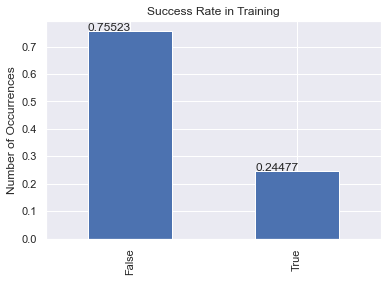

In [10]:
ax = train['requester_received_pizza'].value_counts(normalize=True).plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 5)), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.title('Success Rate in Training')
plt.ylabel('Number of Occurrences', fontsize=12)
pass

We see that there is a **24.5% success rate** in our training set. This is encouraging as although there is a class imbalance in our training dataset, it is not extream. 

### 5. Exploration of non-text features

#### 5.1 requester_number_of_posts_on_raop_at_request

It is evident that most of the requesters in our training set (95.25%) made their first post on RAOP when they requested for pizza. This strongly suggests a novelty effect at play if the training data is representative. When people discover this group and see others requesting pizza, they themselves are encouraged to ask for pizza from an unknown community.

In [11]:
train['requester_number_of_posts_on_raop_at_request'].value_counts()

0    3459
1     132
2      33
3       8
5       3
4       1
Name: requester_number_of_posts_on_raop_at_request, dtype: int64

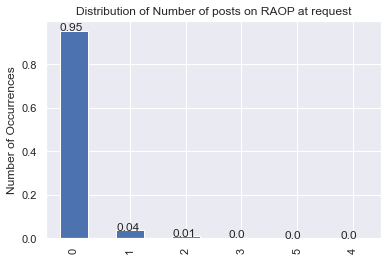

In [12]:
ax = train['requester_number_of_posts_on_raop_at_request'].value_counts(normalize=True).plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.title('Distribution of Number of posts on RAOP at request')
plt.ylabel('Number of Occurrences', fontsize=12)
pass

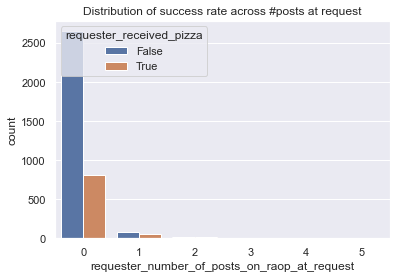

In [13]:
sns.countplot(x = 'requester_number_of_posts_on_raop_at_request', 
              hue='requester_received_pizza', data=train)
plt.title('Distribution of success rate across #posts at request')
pass

#### 5.2 requester_number_of_subreddits_at_request

We see the following pattern 

|Category|sub-reddits|count|Prcnt|
|--|--|--|--|
|New comer|0|656|18.04%|
|Newbie|1-5|730|19.96%|
|Somewhat Engaged|5-10|441|11.41%|
|Medium Engaged|10-50|1510|42.11%|
|Highly Engaged|50-100|267|7.62%|
|Power users|100+|32|0.85%|


This indicates that may be users are finding ROAP via freeform browsing and engaging when needed. Most of the users are existing users of reddit platform. 

In [14]:
pd.cut(train['requester_number_of_subreddits_at_request'], 
       [-np.inf, 0, 5, 10, 50, 100, np.inf], 
       labels=['0. 0','1. 1-5', '2. 5-10', '3. 10-50', '4. 50-100', '5. 100+']).value_counts(normalize=True)

3. 10-50     0.421892
1. 1-5       0.198845
0. 0         0.182068
2. 5-10      0.114411
4. 50-100    0.073982
5. 100+      0.008801
Name: requester_number_of_subreddits_at_request, dtype: float64

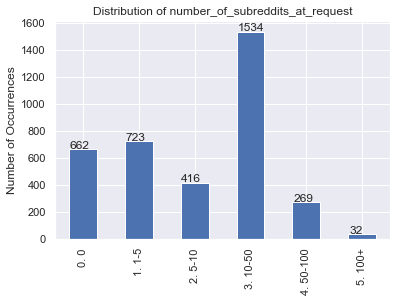

In [15]:
ax = pd.cut(train['requester_number_of_subreddits_at_request'], 
       [-np.inf, 0, 5, 10, 50, 100, np.inf], 
       labels=['0. 0','1. 1-5', '2. 5-10', '3. 10-50', '4. 50-100', '5. 100+']).value_counts().sort_index().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.title('Distribution of number_of_subreddits_at_request')
plt.ylabel('Number of Occurrences', fontsize=12)
pass

In [16]:
# creating the new feature
feat_train = pd.cut(train['requester_number_of_subreddits_at_request'], 
       [-np.inf, 0, 5, 10, 50, 100, np.inf], 
       labels=['0. 0','1. 1-5', '2. 5-10', '3. 10-50', '4. 50-100', '5. 100+'])

feat_val = pd.cut(val['requester_number_of_subreddits_at_request'], 
       [-np.inf, 0, 5, 10, 50, 100, np.inf], 
       labels=['0. 0','1. 1-5', '2. 5-10', '3. 10-50', '4. 50-100', '5. 100+'])

train['num_subreddits_req'] = feat_train
val['num_subreddits_req'] = feat_val

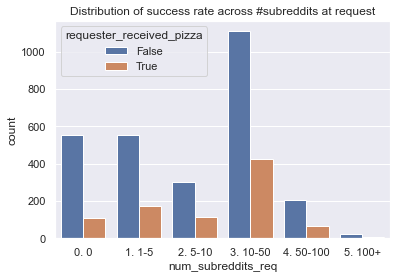

In [17]:
sns.countplot(x = 'num_subreddits_req', hue='requester_received_pizza', data=train)
plt.title('Distribution of success rate across #subreddits at request')
pass

#### 5.3 Unix timestamp of request

In [18]:
# Need to change format of unix timestamp of request, currently it's a float
train['timestamp_converted'] = pd.to_datetime(train['unix_timestamp_of_request'],unit='s')

#### 5.3.1 Distribution by the hour of the day when the request was made

In [19]:
train['hour_bin_4'] = pd.cut(train['timestamp_converted'].dt.hour, 6)
pd.DataFrame(pd.crosstab(train.requester_received_pizza, 
            train.hour_bin_4).apply(lambda r: r/r.sum(), axis=0))

hour_bin_4,"(-0.023, 3.833]","(3.833, 7.667]","(7.667, 11.5]","(11.5, 15.333]","(15.333, 19.167]","(19.167, 23.0]"
requester_received_pizza,,,,,,
False,0.747672,0.81203,0.837838,0.69802,0.719941,0.765411
True,0.252328,0.18797,0.162162,0.30198,0.280059,0.234589


It is seen that different times of the data impact the outcome, with 11 am to 7 pm seeing majority of True requests.

In [20]:
def add_request_hour_feature(data):
    
    hour_bin_6 = pd.cut(data['timestamp_converted'].dt.hour, 6)
    
    return np.reshape(np.array(hour_bin_6),( len(hour_bin_6), 1 ))

In [21]:
add_request_hour_feature(train)

array([[Interval(11.5, 15.333, closed='right')],
       [Interval(19.167, 23.0, closed='right')],
       [Interval(19.167, 23.0, closed='right')],
       ...,
       [Interval(3.833, 7.667, closed='right')],
       [Interval(7.667, 11.5, closed='right')],
       [Interval(15.333, 19.167, closed='right')]], dtype=object)

#### 5.3.4 requester_account_age_in_days_at_request

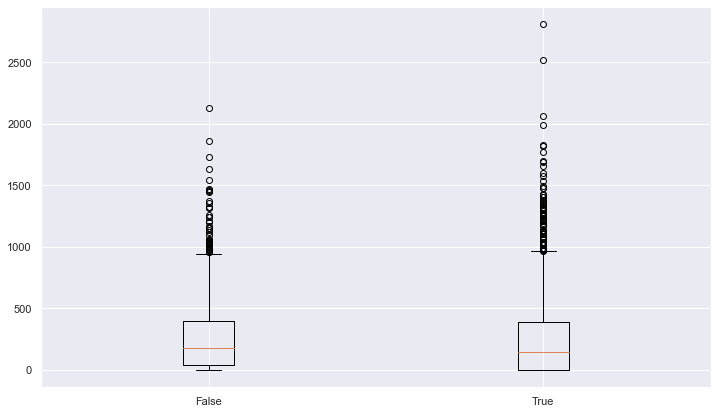

In [22]:
requester_account_age_in_days_at_request_1 = train[train['requester_received_pizza'] == True]['requester_account_age_in_days_at_request']
requester_account_age_in_days_at_request_0 = train[train['requester_received_pizza'] == False]['requester_account_age_in_days_at_request']

set_to_plot = [requester_account_age_in_days_at_request_1, requester_account_age_in_days_at_request_0]

labels = train['requester_received_pizza'].unique()

fig, ax = plt.subplots(figsize=(12, 7))
ax.boxplot(set_to_plot, labels=labels)
pass

The difference in distribution seems more than the other features analyzed below.

#### 5.3.6 requester_subreddits_at_request

In [23]:
requester_subreddits_at_request_1 = train[train['requester_received_pizza'] == True]['requester_subreddits_at_request']
requester_subreddits_at_request_0 = train[train['requester_received_pizza'] == False]['requester_subreddits_at_request']
requester_subreddits_at_request_0

1575                               [Random_Acts_Of_Pizza]
1487    [AskReddit, Assistance, BabyBumps, BabyExchang...
188     [ABraThatFits, AskReddit, BustyPetite, Monster...
12                                                     []
1231    [AdviceAnimals, Ameristralia, AskReddit, IAmA,...
                              ...                        
1095                               [Random_Acts_Of_Pizza]
1294    [AdviceAnimals, AskReddit, Austin, IAmA, fanta...
860                                [Random_Acts_Of_Pizza]
3507    [AskReddit, IAmA, WTF, frederickmd, funny, gam...
3174    [AskReddit, Favors, IAmA, WTF, funny, gaming, ...
Name: requester_subreddits_at_request, Length: 2746, dtype: object

##### 5.3.6.1 Relationship between number of subreddits with activity and altruism

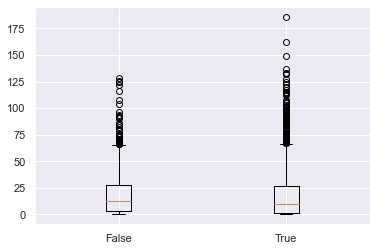

In [24]:
len_requester_subreddits_at_request_1 = []
for r1 in requester_subreddits_at_request_1:
    len_requester_subreddits_at_request_1.append(len(r1))
    
len_requester_subreddits_at_request_0 = []
for r0 in requester_subreddits_at_request_0:
    len_requester_subreddits_at_request_0.append(len(r0))

set_to_plot = [len_requester_subreddits_at_request_1, len_requester_subreddits_at_request_0]

labels = train['requester_received_pizza'].unique()

plt.boxplot(set_to_plot, labels=labels)
pass

Those with fulfilled pizza requests seem to be (on average) lesser active in subreddits than those with unfulfilled requests.

##### 5.3.6.2 Relationship between number of "Random" subreddits with activity and altruism

Analyzing activity in the following subreddits:

In [25]:
def find_subreddits(data, to_look_for):
    found_subreddits = []
    for subreddit_list in data['requester_subreddits_at_request']:
        temp = []
        if not subreddit_list:
            found_subreddits.append(temp)
        else:
            for subreddits in subreddit_list:
                if to_look_for.lower() in subreddits.lower():
                    temp.append(subreddits)
                else:
                    continue
            found_subreddits.append(temp)              
#                 splits_by_line = subreddits.replace(']','').replace('[','').split('\n')
#                 splits_subreddits = [s.replace("'","").split(",") for s in splits_by_line]
#             found_subreddits.append([r for r in splits_subreddits[0] if to_look_for.lower() in r.lower()])
    return found_subreddits

In [104]:
def num_random_subreddits_feature(data):
    
    num_random_sr = [len(x) for x in find_subreddits(data, "Random")]
    
    return np.reshape(np.array(num_random_sr),( len(num_random_sr), 1 ))

In [105]:
len(num_random_subreddits_feature(val))

404

In [102]:
len(val)

404

##### 5.3.6.3 Relationship between activity in "Random_Acts_Of_Pizza" subreddits and altruism

In [106]:
def num_raop_subreddits_feature(data):
    
    num_raop_sr = [len(x) for x in find_subreddits(data, "Random_Acts_Of_Pizza")]
    
    return np.reshape(np.array(num_raop_sr),( len(num_raop_sr), 1 ))

In [29]:
num_raop_subreddits_feature(train)

array([[1],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

##### 5.3.6.4 Relationship between activity in 'pizza' related subreddits and altruism

In [107]:
def num_food_subreddits_feature(data):
    
    num_food_sr = [len(x) for x in find_subreddits(data, "food")]
    
    return np.reshape(np.array(num_food_sr),( len(num_food_sr), 1 ))

In [31]:
num_food_subreddits_feature(train)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

##### What types of subreddits are most commonly associated with pizza request fulfilment

In [32]:
def commonly_associated_subreddits(data):
    subreddits_frequency = {}
    for r1 in requester_subreddits_at_request_1:
        for s in r1:
            subreddits_frequency[s] = subreddits_frequency.get(s, 0) + 1
    return sorted(subreddits_frequency.items(), key=lambda item: item[1], reverse = True)

In [33]:
commonly_associated_subreddits(train)[0:10]

[('AskReddit', 568),
 ('pics', 490),
 ('funny', 468),
 ('WTF', 370),
 ('IAmA', 369),
 ('Random_Acts_Of_Pizza', 364),
 ('gaming', 356),
 ('videos', 284),
 ('todayilearned', 267),
 ('reddit.com', 263)]

In [111]:
def activity_in_commonly_associated_subreddits(data):
    activities = []
    for casr in commonly_associated_subreddits(data)[0:10]:
        activity_array = [len(x) for x in find_subreddits(data, casr[0])]
        activity = np.reshape(np.array(activity_array),( len(activity_array), 1 ))
        if(len(activities)==0):
            activities = activity
        else:
            activities = np.hstack((activities, activity))
    return activities

#### 5.4 requester_upvotes_minus_downvotes_at_request

1381.3505617977528
1068.4442825928622


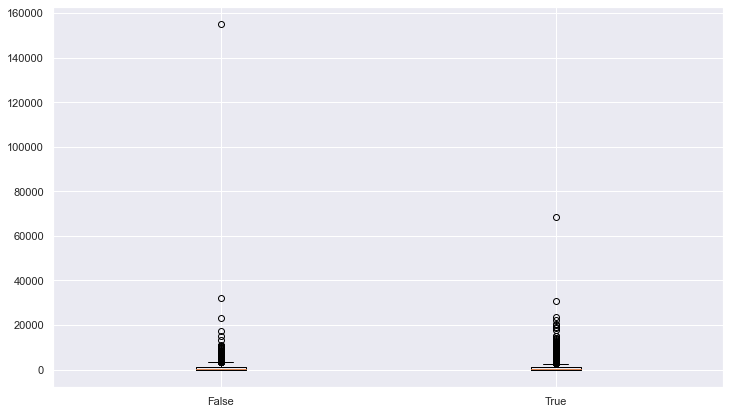

In [36]:
requester_upvotes_minus_downvotes_at_request_1 = train[train['requester_received_pizza'] == True]['requester_upvotes_minus_downvotes_at_request']
requester_upvotes_minus_downvotes_at_request_0 = train[train['requester_received_pizza'] == False]['requester_upvotes_minus_downvotes_at_request']

set_to_plot = [requester_upvotes_minus_downvotes_at_request_1, requester_upvotes_minus_downvotes_at_request_0]

labels = train['requester_received_pizza'].unique()

fig, ax = plt.subplots(figsize=(12, 7))
ax.boxplot(set_to_plot, labels=labels)

print(np.mean(requester_upvotes_minus_downvotes_at_request_1))
print(np.mean(requester_upvotes_minus_downvotes_at_request_0))

In [37]:
requester_upvotes_minus_downvotes_at_request_1 = train[train['requester_received_pizza'] == True]['requester_upvotes_minus_downvotes_at_request']
requester_upvotes_minus_downvotes_at_request_0 = train[train['requester_received_pizza'] == False]['requester_upvotes_minus_downvotes_at_request']
print(len(requester_upvotes_minus_downvotes_at_request_1))
#removing outliers
z = np.abs(stats.zscore(requester_upvotes_minus_downvotes_at_request_1))
#print(z)
requester_upvotes_minus_downvotes_at_request_1_removed_outliers = requester_upvotes_minus_downvotes_at_request_1.where(z < 2)
print(len(requester_upvotes_minus_downvotes_at_request_1_removed_outliers))

print(len(requester_upvotes_minus_downvotes_at_request_0))
#removing outliers
z = np.abs(stats.zscore(requester_upvotes_minus_downvotes_at_request_0))
#print(z)
requester_upvotes_minus_downvotes_at_request_0_removed_outliers = requester_upvotes_minus_downvotes_at_request_0.where(z < 2)
print(len(requester_upvotes_minus_downvotes_at_request_0_removed_outliers))

890
890
2746
2746


#### 5.5 requester_upvotes_plus_downvotes_at_request

5146.087640449438
3189.305171158048


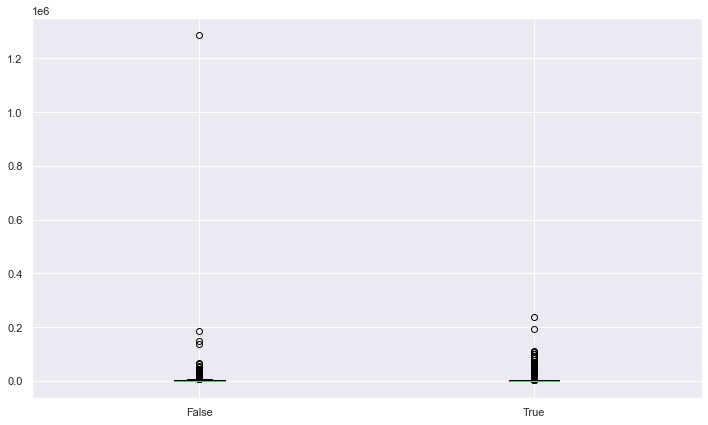

In [38]:
requester_upvotes_plus_downvotes_at_request_1 = train[train['requester_received_pizza'] == True]['requester_upvotes_plus_downvotes_at_request']
requester_upvotes_plus_downvotes_at_request_0 = train[train['requester_received_pizza'] == False]['requester_upvotes_plus_downvotes_at_request']

set_to_plot = [requester_upvotes_plus_downvotes_at_request_1, requester_upvotes_plus_downvotes_at_request_0]

labels = train['requester_received_pizza'].unique()

fig, ax = plt.subplots(figsize=(12, 7))
ax.boxplot(set_to_plot, labels=labels)

print(np.mean(requester_upvotes_plus_downvotes_at_request_1))
print(np.mean(requester_upvotes_plus_downvotes_at_request_0))

### 6. Exploration of text-based features

### 6.1 Creating new features from text

In [39]:
request_text_features = train[['request_text_edit_aware']]
request_labels = train[['requester_received_pizza']]
request_text_features.head()

,request_text_edit_aware
1575,I'm a liberal arts student with zero dollars t...
1614,For the past months since I've been home fro...
1487,"Broke, pregnant and hungry. We won't get foods..."
188,our cat always jumps onto the counter when we ...
12,I am a stay at home mom of two kids i live wit...


In [40]:
text0 = "I'm a liberal arts student with zero dollars to my name and getting desperate. I'd be gracious and thankful for a pizza today\n"
text1 = "  For the past months since I've been home from college my family's living situation has gone from bad to terrible.  My mom has been in and out work for even longer, and its been difficult to keep food in the home. Along with my Dad skipping out of child support payments and bills looming it hasn't been easy.  \n\n Me and my brother have been basically eating fried rice and beans for the last few weeks and could really use a decent meal like a hot fresh pizza.\n\n"

In [41]:
def lengths_feature(data):
    
    lengths = [len(t) for t in data['request_text_edit_aware']]
    
    return np.reshape(np.array(lengths),( len(lengths), 1 ))

In [42]:
def num_words_feature(data):
        
    words = [len(x.split()) for x in data['request_text_edit_aware']]
        
    return np.reshape(np.array(words),( len(words), 1 ))

In [43]:
def num_caps_feature(data):
    
    caps = [sum(1 for word in x.split() for c in word if c.isupper()) for x in data['request_text_edit_aware']]

    return np.reshape(np.array(caps),(len(caps), 1))

In [44]:
def caps_vs_lengths_feature(data):
    
    caps_vs_lengths = [sum(1 for word in x.split() for c in word if c.isupper())/
                       len(x) if len(x)>0 else 0 for x in data['request_text_edit_aware']]
    return np.reshape(np.array(caps_vs_lengths),(len(caps_vs_lengths), 1))

In [45]:
def num_unique_words_feature(data):
    
    num_unique_words = [len(set(w for w in x.split())) for x in data['request_text_edit_aware']]

    return np.reshape(np.array(num_unique_words),(len(num_unique_words), 1))

In [46]:
def num_punctuations_feature(data):
    
    puncs = '!"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`'

    num_punctuations = [sum(x.count(w) for w in puncs) for x in data['request_text_edit_aware']]

    return np.reshape(np.array(num_punctuations),(len(num_punctuations), 1))

In [47]:
def requests_with_url(data):
    
    url_regex = re.compile(r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))")

    requests_with_url = [1 if len([f[0] for f in re.findall(url_regex,str(x))])>0 else 0 for x in data['request_text_edit_aware']]
    
    return np.reshape(np.array(requests_with_url),(len(requests_with_url), 1))

In [48]:
def testTextFeatures():
    puncs = '!"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`'
    url_regex = re.compile(r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))")

    try:
        assert lengths_feature(train)[0][0]==len(text0)
        assert lengths_feature(train)[1][0]==len(text1)
        
        assert num_words_feature(train)[0][0]==len(text0.split())
        assert num_words_feature(train)[1][0]==len(text1.split())
        
        assert num_caps_feature(train)[0][0]==sum([1 for word in text0.split() for c in word if c.isupper()])
        assert num_caps_feature(train)[1][0]==sum([1 for word in text1.split() for c in word if c.isupper()])
        
        assert caps_vs_lengths_feature(train)[0][0]==sum([1 for word in text0.split() for c in word if c.isupper()])/len(text0)
        assert caps_vs_lengths_feature(train)[1][0]==sum([1 for word in text1.split() for c in word if c.isupper()])/len(text1)
        assert caps_vs_lengths_feature(train)[7][0]==0
        
        assert num_unique_words_feature(train)[0][0]==len(set(w for w in text0.split()))
        assert num_unique_words_feature(train)[1][0]==len(set(w for w in text1.split()))
        
        assert num_punctuations_feature(train)[0][0]==sum(text0.count(w) for w in puncs)
        assert num_punctuations_feature(train)[1][0]==sum(text1.count(w) for w in puncs)
        
        assert requests_with_url(train)[0][0]==(1 if len(re.findall(url_regex,str(text0)))>0 else 0)
        assert requests_with_url(train)[1000][0]==(1 if len(re.findall(url_regex,str(train['request_text_edit_aware'].values[1000])))>0 else 0)
        
        return "All tests passed!"
    except AssertionError as error:
        print("Error found:", error)
testTextFeatures()

'All tests passed!'

## 6.2 Adding Request and Text Meta Features to transformed data set

In [112]:
def add_text_and_request_features_df(data):
    data_pandas_df = pd.DataFrame(data)
    data_pandas_df['lengths_text'] = lengths_feature(data)
    data_pandas_df['num_words_text'] = num_words_feature(data)
    data_pandas_df['num_caps_text'] = num_caps_feature(data)
    data_pandas_df['capsvslen_text'] = caps_vs_lengths_feature(data)
    data_pandas_df['num_unique_words_text'] = num_unique_words_feature(data)
    data_pandas_df['num_puncs_text'] = num_punctuations_feature(data)
    data_pandas_df['num_req_w_url_text'] = requests_with_url(data)
    #data_pandas_df['request_hour']=add_request_hour_feature(data).tolist()
    data_pandas_df['active_random_subr'] = num_random_subreddits_feature(data)
    data_pandas_df['active_raop_subr'] = num_raop_subreddits_feature(data)
    data_pandas_df['active_food_subr'] = num_food_subreddits_feature(data)
    
    acts = activity_in_commonly_associated_subreddits(data)
    prefix_act = 'active_common_sr_'
    for a in range(acts.shape[1]):
        data_pandas_df[prefix_act+str(a)] = acts[:,a]

    return data_pandas_df

### 6.2 Feature Preprocessing 

The first step for text processing is to set up the preprocessing functions. In our preprocessing steps, we are doing the following:

1. Coverting the text to lower case
2. Removing stopwords
3. Removing digits
4. Lemmatizing the word tokens

### 6.2.1 Creating stopword list

Added a couple of custom stopwords that are frequently used in ROAP requests (e.g. piza, request, hey, hi)

In [88]:
# stopwords from stopwords-json
stopwords_json = {"en":["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]}
stopwords_json_en = set(stopwords_json['en'])
# adding some of our own stop words to NLTK's stopword list
stopwords_nltk_en = set(stopwords.words('english') + ['though','pizza', 'request', 'hey', 'hi'])
# create stop word list for punctuation
stopwords_punct = set(punctuation)
# combine the three stopwords lists
stoplist_combined = set.union(stopwords_json_en, stopwords_nltk_en, stopwords_punct)

### 6.2.2 Create Text Pre-processor
Added the ability to replace contractions with their proper form and remove URLS to the text preprocessor

In [86]:
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

def preprocess_text_1(text):
    # Input: str, i.e. document/sentence
    # Output: list(str) , i.e. list of lemmas
    # added functions to replace contractions with their proper form
    # and remove any URLs
    processed_list = [word for word in lemmatize_sent(text)
            if word not in stoplist_combined
            and not word.isdigit()]
    processed_text = ' '.join(processed_list) 
    return processed_text


def preprocess_text_2(text):
    # Input: str, i.e. document/sentence
    # Output: list(str) , i.e. list of lemmas
    return ' '.join([word for word in lemmatize_sent(text) 
            if word not in stoplist_combined
            and not word.isdigit()])

def preprocess_text(text):
    # Input: str, i.e. document/sentence
    # Output: list(str) , i.e. list of lemmas
    return [word for word in lemmatize_sent(text) 
            if word not in stoplist_combined
            and not word.isdigit()]

### 6.3 Using TFIDFVectorizer for Bigrams

In [89]:
# Initialize bigram TDIFD vectorizer 
tf_bigram = TfidfVectorizer(analyzer = 'word', preprocessor = preprocess_text_1, ngram_range = (2, 2))
train_bigram = tf_bigram.fit_transform(train['request_text_edit_aware'])

# average frequency of ngrams
avg_values = train_bigram.toarray().sum(axis=0)
# list of ngrams
vocab = tf_bigram.vocabulary_
df_bigram = pd.DataFrame(sorted([(avg_values[i],k) for k,i in vocab.items()], reverse=True)).rename(columns={0: 'sum frequency', 1:'bigram'})

In [90]:
df_bigram[:20]

,sum frequency,bigram
0,37.914944,pay forward
1,17.896445,imgur com
2,17.438381,college student
3,17.423593,http imgur
4,15.198332,return favor
5,13.729342,sob story
6,13.667979,bank account
7,13.119734,lose job
8,10.750201,ll pay
9,10.088778,pay back


### 6.4 Topic Modeling using LDA (Latent Dirichlet Allocation)

After using the TDIDF vectorizer to create bigrams, we looked into whether similar bigrams can be grouped into topics. One method we used for topic modeling is LDA.

LDA is an iterative probabilistic model that creates topics using two probability values: P(Word|Topic) and P(Topic|Document). We set the LDA model tocreate 10 topics. First, LDA will randomly assign bigrams to 10 topics. Then it'll use the two probability values to reassign bigrams to topics. The reassignment step will happen over and over again until the model converges. This results is the final 10 topics.

In [91]:
# topics for TFIDF trigrams using LDA
lda = LatentDirichletAllocation(n_components=10)
pipe_lda = make_pipeline(tf_bigram, lda)
pipe_lda.fit(train['request_text_edit_aware'])
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
print_top_words(lda, tf_bigram.get_feature_names(), n_top_words=5)

Topic #0: pay forward, college student, sob story, imgur com, pay week
Topic #1: pay forward, sob story, pay back, bank account, http imgur
Topic #2: pay forward, http imgur, imgur com, bank account, pay rent
Topic #3: pay forward, lose job, spend money, bank account, return favor
Topic #4: pay forward, http imgur, imgur com, return favor, food money
Topic #5: pay forward, sob story, college student, money food, imgur com
Topic #6: pay forward, imgur com, http imgur, family love, pay friday
Topic #7: return favor, pay forward, college student, kind soul, http imgur
Topic #8: pay forward, http imgur, imgur com, sob story, food house
Topic #9: pay forward, ll pay, return favor, broke college, college student



### 6.5 Topic Modeling using NMF (Non-negative Matrix Factorization)

Another topic modeling method we used was NMF. NMF is a linear algebreic model that moves from higher dimensionality to lower dimensionality. It makes a given document-word matrix (our TDIDF matrix) and factors it into two lower dimensional forms: one is a vector of topics and another is a matrix of topic weights for each document. The two lower dimensionality forms are calculated by iterating over them until them optimize and coverge.

Below we used NMF to create 10 topics like we did above with LDA modeling. From NMF we saw topics that seemed to make more sense and have less repetition.

In [92]:
## topics for TFIDF trigrams using NMF
nmf = NMF(n_components=10)
pipe = make_pipeline(tf_bigram, nmf)
pipe.fit(train['request_text_edit_aware'])
print_top_words(nmf, tf_bigram.get_feature_names(), n_top_words=5)

Topic #0: pay forward, ll pay, promise pay, forward asap, forward money
Topic #1: imgur com, http imgur, proof http, dxye3 jpg, com dxye3
Topic #2: college student, broke college, hungry college, break college, student ll
Topic #3: return favor, gladly return, love return, favor paycheck, title return
Topic #4: money food, eat today, food eat, food hungry, hungry nice
Topic #5: sob story, real sob, random act, story hungry, give sob
Topic #6: http www, reddit com, www reddit, random_acts_of_pizza comments, com random_acts_of_pizza
Topic #7: pay week, pay back, forward pay, pay friday, back forward
Topic #8: lose job, job week, week ago, job couple, job month
Topic #9: bank account, cent bank, ca afford, past week, make day



/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [93]:
## topics for TFIDF trigrams using NMF for those who did get pizza
nmf = NMF(n_components=10)
pipe = make_pipeline(tf_bigram, nmf)
pipe.fit(train.request_text_edit_aware[train.requester_received_pizza == True])
print_top_words(nmf, tf_bigram.get_feature_names(), n_top_words=5)

Topic #0: imgur com, http imgur, proof http, com cpw0q, cat http
Topic #1: pay forward, ll pay, forward money, promise pay, forward re
Topic #2: pay week, reciprocate pay, leave house, cereal egg, house mood
Topic #3: ca afford, eat ramen, lose job, make day, sob story
Topic #4: college student, ve live, peanut butter, friday random, make friday
Topic #5: return favor, love return, pay friday, fee day, friday love
Topic #6: bank account, pay bank, eat day, empty bank, dollar bank
Topic #7: money food, hungry nice, food hungry, leave money, weekend leave
Topic #8: job pay, work week, pay month, pay work, finally job
Topic #9: http www, www reddit, reddit com, gift card, com random_acts_of_pizza



In [94]:
## topics for TFIDF trigrams using NMF for those who did not get piza
nmf = NMF(n_components=10)
pipe = make_pipeline(tf_bigram, nmf)
pipe.fit(train.request_text_edit_aware[train.requester_received_pizza == False])
print_top_words(nmf, tf_bigram.get_feature_names(), n_top_words=5)

Topic #0: pay forward, forward asap, promise pay, forward pay, will pay
Topic #1: imgur com, http imgur, k4mz7kr png, com k4mz7kr, com dxye3
Topic #2: college student, broke college, hungry college, break college, student ll
Topic #3: return favor, gladly return, favor paycheck, title return, guy forever
Topic #4: bank account, money food, eat today, make day, couple day
Topic #5: sob story, random act, story random, give sob, wan na
Topic #6: http www, reddit com, www reddit, youtube com, com watch
Topic #7: pay back, pay friday, pay week, forward pay, love pay
Topic #8: lose job, job couple, job month, job week, month ago
Topic #9: ll pay, pay forward, advance ll, money ll, hungry money



### 6.6 PMI Calculation
The idea of PMI is that we want to quantify the likelihood of co-occurrence of two words, taking into account the fact that it might be caused by the frequency of the single words. Hence, the algorithm computes the (log) probability of co-occurrence scaled by the product of the single probability of occurrence as follows:


$$
PMI (a, b) = \log(\frac{P(a, b)}{P(a) * P(b)})
$$

Now, knowing that, when ‘a’ and ‘b’ are independent, their joint probability is equal to the product of their marginal probabilities, when the ratio equals 1 (hence the log equals 0), it means that the two words together don’t form a unique concept: they co-occur by chance.

It is important to note that we can use PMI criterion to not just detect the collocation of two words. We can also use it to get a sense of if a word and a class are co-occuring togather or not. This is the way we are going to use PMI in our case. 

#### 6.6.1 Counting inclass and overall frequencies for all words in training dataset

The next step is to start with the pre-processed text and identify the occurance frequency for each token in the training and test dataset. 

In [95]:
def count_words_per_category(v, out):
    result_true, result_false, result_vocab = {}, {}, {}
    for ind, line in enumerate(v):
        #print(ind)
        #print(out[ind])
        trf_line = preprocess_text(line) # preprocess and lammatized title text
        for elem in trf_line:
            result_vocab[elem] = result_vocab.get(elem, 0) + 1
            
            if out[ind]:
                result_true[elem] = result_true.get(elem, 0) + 1
            else: 
                result_false[elem] = result_false.get(elem, 0) + 1
    
    return result_true, result_false, result_vocab

#### 6.6.2 Implementing the PMI function

In the next step, we implement the PMI function and compute PMI for all the words in the dictionary

In [96]:
def pmi(inclass_freq, total_freq, class_freq, min_count=10):
    """
    inclass_freq (dict): dictionary containing inclass frequency for a given word
    total_freq (dict): dictionary containing total frequency for a given word
    class_freq (float): class prevalence
    min_count (int): minimum frequency for pmi calculation
    """
    pmi = {}
    for word, freq in total_freq.items():
        if freq < min_count:
            continue
        pmi[word] = np.log((inclass_freq.get(word, 0) + 0.001) * 1.0 / (class_freq * freq))
    return pmi

### 7. Feature Engineering

#### 7.1 non-text features

Looking at the data, there are just few text fields and a lot of non-text features present. We start with creating the non-text features first and then add text based features on top. 

In [97]:
# feature 1 - number of posts on ROAP at request

def num_posts_roap(data, colname, id_colname,th=0):
    """
    data (pandas dataframe): inout data frame
    colname (str): original column name
    id_colname (str): identifier for the created feature
    th (int): threshold for creating binary feature
    """
    new_colname = id_colname + '_' +colname
    feat = np.where(data[colname] == th, 0, 1)
    data[new_colname] = feat
    del data[colname]
    return data

In [98]:
# feature 2 - number subreddits dummy variables

def num_subreddit_dummy(data, colname):
    """
    data (pandas dataframe): inout data frame
    colname (str): original column name
    """
    return pd.get_dummies(data=data, columns=[colname], drop_first=True)

### Preparing the training data

In [113]:
train_final = add_text_and_request_features_df(train)
val_final = add_text_and_request_features_df(val)

In [114]:
train_final = num_posts_roap(data=train_final, 
                             colname='requester_number_of_posts_on_raop_at_request', 
                             id_colname='binary')

val_final = num_posts_roap(data=val_final, 
                             colname='requester_number_of_posts_on_raop_at_request', 
                             id_colname='binary')

In [115]:
train_final = num_subreddit_dummy(data = train_final, colname= 'num_subreddits_req')
val_final = num_subreddit_dummy(data = val_final, colname= 'num_subreddits_req')

In [116]:
val_final.columns

Index(['requester_received_pizza', 'request_title', 'request_text_edit_aware',
       'requester_number_of_subreddits_at_request',
       'unix_timestamp_of_request', 'requester_account_age_in_days_at_request',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'lengths_text',
       'num_words_text', 'num_caps_text', 'capsvslen_text',
       'num_unique_words_text', 'num_puncs_text', 'num_req_w_url_text',
       'active_random_subr', 'active_raop_subr', 'active_food_subr',
       'active_common_sr_0', 'active_common_sr_1', 'active_common_sr_2',
       'active_common_sr_3', 'active_common_sr_4', 'active_common_sr_5',
       'active_common_sr_6', 'active_common_sr_7', 'active_common_sr_8',
       'active_common_sr_9',
       'binary_requester_number_of_posts_on_raop_at_request',
       'num_subreddits_req_1. 1-5', 'num_subreddits_req_2. 5-10',
       'num_subreddits_req_3. 10-50', 'num_su

#### 7.2 Text feature extraction

We start by extacting the top 20 words from both text and title columns w.r.t. PMI criterion. For that we need to calculate the inclass frequencies and compute PMI as noted in above code. 

In [117]:
def get_counts(data, text_colname, outcome_colname):
    return count_words_per_category(data[text_colname], 
                                    list(data[outcome_colname]))

def get_top_k_from_dict(d, k):
    return sorted(d.items(), key=lambda kv: kv[1])[-k:]

def get_words(sorted_dict):
    return [w[0] for w in sorted_dict]

def calculate_pmi(data, text_colname, outcome_colname, class_freq_true, top_k):
    count_class_true, count_class_false, count_total = get_counts(data = data, 
                                                         text_colname=text_colname, 
                                                         outcome_colname=outcome_colname) 
    pmi_true = pmi(inclass_freq=count_class_true, 
                   total_freq=count_total, 
                   class_freq=class_freq_true)
    
    pmi_false = pmi(inclass_freq=count_class_false, 
                   total_freq=count_total, 
                   class_freq=1-class_freq_true)
    
    pmi_true_top_k = get_top_k_from_dict(pmi_true, k=top_k)
    pmi_false_top_k = get_top_k_from_dict(pmi_false, k=top_k)
    
    pmi_true_words = get_words(pmi_true_top_k)
    pmi_false_words = get_words(pmi_false_top_k)
    
    return pmi_true_words, pmi_false_words


In [118]:
true_class_pmi_words_title, false_class_pmi_words_title = calculate_pmi(data = train_final, 
                                                                        text_colname='request_title', 
                                                                        outcome_colname='requester_received_pizza', 
                                                                        class_freq_true=0.24505, 
                                                                        top_k=20)

In [119]:
true_class_pmi_words_text, false_class_pmi_words_text = calculate_pmi(data = train_final, 
                                                                      text_colname='request_text_edit_aware', 
                                                                      outcome_colname='requester_received_pizza', 
                                                                      class_freq_true=0.24505, 
                                                                      top_k=20)

In [120]:
# Creating text features - token counts
def simple_token_count(v):
    result = []
    for line in v:
        if line != line:
            result.append(1)
            continue
        result.append(len(word_tokenize(line)))
    return result

In [121]:
title_length_train = simple_token_count(train_final.request_title)
title_length_val = simple_token_count(val_final.request_title)
text_length_train = simple_token_count(train_final.request_text_edit_aware)
text_length_val = simple_token_count(val_final.request_text_edit_aware)

In [122]:
train_final['title_length'] = title_length_train
train_final['text_length'] = text_length_train
val_final['title_length'] = title_length_val
val_final['text_length'] = text_length_val

In [123]:
train_final.columns

Index(['requester_received_pizza', 'request_title', 'request_text_edit_aware',
       'requester_number_of_subreddits_at_request',
       'unix_timestamp_of_request', 'requester_account_age_in_days_at_request',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'timestamp_converted',
       'hour_bin_4', 'lengths_text', 'num_words_text', 'num_caps_text',
       'capsvslen_text', 'num_unique_words_text', 'num_puncs_text',
       'num_req_w_url_text', 'active_random_subr', 'active_raop_subr',
       'active_food_subr', 'active_common_subr', 'active_common_sr_0',
       'active_common_sr_1', 'active_common_sr_2', 'active_common_sr_3',
       'active_common_sr_4', 'active_common_sr_5', 'active_common_sr_6',
       'active_common_sr_7', 'active_common_sr_8', 'active_common_sr_9',
       'binary_requester_number_of_posts_on_raop_at_request',
       'num_subreddits_req_1. 1-5', 'num_subreddits_

In [124]:
val_final.columns

Index(['requester_received_pizza', 'request_title', 'request_text_edit_aware',
       'requester_number_of_subreddits_at_request',
       'unix_timestamp_of_request', 'requester_account_age_in_days_at_request',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'lengths_text',
       'num_words_text', 'num_caps_text', 'capsvslen_text',
       'num_unique_words_text', 'num_puncs_text', 'num_req_w_url_text',
       'active_random_subr', 'active_raop_subr', 'active_food_subr',
       'active_common_sr_0', 'active_common_sr_1', 'active_common_sr_2',
       'active_common_sr_3', 'active_common_sr_4', 'active_common_sr_5',
       'active_common_sr_6', 'active_common_sr_7', 'active_common_sr_8',
       'active_common_sr_9',
       'binary_requester_number_of_posts_on_raop_at_request',
       'num_subreddits_req_1. 1-5', 'num_subreddits_req_2. 5-10',
       'num_subreddits_req_3. 10-50', 'num_su

In [125]:
## Advanced word matching features

w_vect = gensim.downloader.load('glove-twitter-50')

In [126]:
def get_binary_feature(word, vector, wv):
    result = []
    candidates = set([w[0] for w in wv.most_similar(word, topn=20)] + [word])
    for line in vector:
        if line != line:
            result.append(0)
            continue
        trf_line = preprocess_text(line)
        if len(candidates.intersection(set(trf_line))) > 0:
            result.append(1)
        else:
            result.append(0)
    return result

def text_feature_addition(word_list, df, colname, id_str, wv):
    for ind, word in enumerate(word_list):
        print(ind, ' : ', word)
        f_name = id_str + word
        feat = get_binary_feature(word, df[colname], wv)
        df[f_name] = feat
    return df

In [127]:
train_final = text_feature_addition(word_list=false_class_pmi_words_text, 
                                    df=train_final, 
                                    colname='request_text_edit_aware', 
                                    wv=w_vect, 
                                    id_str='text_false_')

train_final = text_feature_addition(word_list=true_class_pmi_words_text, 
                                    df=train_final, 
                                    colname='request_text_edit_aware', 
                                    wv=w_vect, 
                                    id_str='text_true_')

train_final = text_feature_addition(word_list=false_class_pmi_words_title, 
                                    df=train_final, 
                                    colname='request_title', 
                                    wv=w_vect, 
                                    id_str='title_false_')

train_final = text_feature_addition(word_list=true_class_pmi_words_title, 
                                    df=train_final, 
                                    colname='request_title', 
                                    wv=w_vect, 
                                    id_str='title_true_')

0  :  page
1  :  lover
2  :  country
3  :  remove
4  :  username
5  :  sibling
6  :  economy
7  :  smoke
8  :  shelter
9  :  favour
10  :  drunk
11  :  english
12  :  ta
13  :  animal
14  :  ga
15  :  dead
16  :  essay
17  :  bc
18  :  tide
19  :  fancy
0  :  fly
1  :  exchange
2  :  remain
3  :  earn
4  :  subsist
5  :  partner
6  :  basic
7  :  stone
8  :  leg
9  :  dvd
10  :  individual
11  :  puppy
12  :  fry
13  :  sum
14  :  admit
15  :  kidney
16  :  lawyer
17  :  collect
18  :  package
19  :  bonus
0  :  saturday
1  :  hell
2  :  london
3  :  great
4  :  houston
5  :  slice
6  :  pick
7  :  colorado
8  :  fuck
9  :  play
10  :  people
11  :  ct
12  :  jersey
13  :  order
14  :  noodle
15  :  enjoy
16  :  na
17  :  pepperoni
18  :  wan
19  :  class
0  :  rough
1  :  real
2  :  holiday
3  :  redditor
4  :  iowa
5  :  yesterday
6  :  arizona
7  :  kentucky
8  :  los
9  :  angeles
10  :  fail
11  :  smile
12  :  anniversary
13  :  nj
14  :  father
15  :  baby
16  :  daughter
17  : 

In [128]:
val_final = text_feature_addition(word_list=false_class_pmi_words_text, 
                                    df=val_final, 
                                    colname='request_text_edit_aware', 
                                    wv=w_vect, 
                                    id_str='text_false_')

val_final = text_feature_addition(word_list=true_class_pmi_words_text, 
                                    df=val_final, 
                                    colname='request_text_edit_aware', 
                                    wv=w_vect, 
                                    id_str='text_true_')

val_final = text_feature_addition(word_list=false_class_pmi_words_title, 
                                    df=val_final, 
                                    colname='request_title', 
                                    wv=w_vect, 
                                    id_str='title_false_')

val_final = text_feature_addition(word_list=true_class_pmi_words_title, 
                                    df=val_final, 
                                    colname='request_title', 
                                    wv=w_vect, 
                                    id_str='title_true_')

0  :  page
1  :  lover
2  :  country
3  :  remove
4  :  username
5  :  sibling
6  :  economy
7  :  smoke
8  :  shelter
9  :  favour
10  :  drunk
11  :  english
12  :  ta
13  :  animal
14  :  ga
15  :  dead
16  :  essay
17  :  bc
18  :  tide
19  :  fancy
0  :  fly
1  :  exchange
2  :  remain
3  :  earn
4  :  subsist
5  :  partner
6  :  basic
7  :  stone
8  :  leg
9  :  dvd
10  :  individual
11  :  puppy
12  :  fry
13  :  sum
14  :  admit
15  :  kidney
16  :  lawyer
17  :  collect
18  :  package
19  :  bonus
0  :  saturday
1  :  hell
2  :  london
3  :  great
4  :  houston
5  :  slice
6  :  pick
7  :  colorado
8  :  fuck
9  :  play
10  :  people
11  :  ct
12  :  jersey
13  :  order
14  :  noodle
15  :  enjoy
16  :  na
17  :  pepperoni
18  :  wan
19  :  class
0  :  rough
1  :  real
2  :  holiday
3  :  redditor
4  :  iowa
5  :  yesterday
6  :  arizona
7  :  kentucky
8  :  los
9  :  angeles
10  :  fail
11  :  smile
12  :  anniversary
13  :  nj
14  :  father
15  :  baby
16  :  daughter
17  : 

In [129]:
train_final.columns

Index(['requester_received_pizza', 'request_title', 'request_text_edit_aware',
       'requester_number_of_subreddits_at_request',
       'unix_timestamp_of_request', 'requester_account_age_in_days_at_request',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'timestamp_converted',
       ...
       'title_true_fail', 'title_true_smile', 'title_true_anniversary',
       'title_true_nj', 'title_true_father', 'title_true_baby',
       'title_true_daughter', 'title_true_tucson', 'title_true_happy',
       'title_true_lot'],
      dtype='object', length=120)

In [130]:
val_final.columns

Index(['requester_received_pizza', 'request_title', 'request_text_edit_aware',
       'requester_number_of_subreddits_at_request',
       'unix_timestamp_of_request', 'requester_account_age_in_days_at_request',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'lengths_text',
       ...
       'title_true_fail', 'title_true_smile', 'title_true_anniversary',
       'title_true_nj', 'title_true_father', 'title_true_baby',
       'title_true_daughter', 'title_true_tucson', 'title_true_happy',
       'title_true_lot'],
      dtype='object', length=117)

### 8. Model training and baseline results

In [200]:
exc_col = ['requester_received_pizza', 'request_title', 'request_text_edit_aware', 'unix_timestamp_of_request', 
          'requester_subreddits_at_request', 'timestamp_converted', 'hour_bin_4','active_common_subr']
Xcols = [c for c in train_final.columns.tolist() if c not in exc_col]

In [201]:
train_final[Xcols].isna().sum()

requester_number_of_subreddits_at_request       0
requester_account_age_in_days_at_request        0
requester_upvotes_minus_downvotes_at_request    0
requester_upvotes_plus_downvotes_at_request     0
lengths_text                                    0
                                               ..
title_true_baby                                 0
title_true_daughter                             0
title_true_tucson                               0
title_true_happy                                0
title_true_lot                                  0
Length: 112, dtype: int64

In [202]:
train_final[Xcols].shape

(3636, 112)

In [203]:
train_final[y_col].shape

(3636,)

In [178]:
txcols = train_final[Xcols]

In [199]:
types = []
for x in Xcols:
    print(x)
    for d in txcols[x]:
        print(type(d))
        types.append(type(d))
        break
print(set(types))

requester_number_of_subreddits_at_request
<class 'int'>
requester_account_age_in_days_at_request
<class 'float'>
requester_upvotes_minus_downvotes_at_request
<class 'int'>
requester_upvotes_plus_downvotes_at_request
<class 'int'>
lengths_text
<class 'int'>
num_words_text
<class 'int'>
num_caps_text
<class 'int'>
capsvslen_text
<class 'float'>
num_unique_words_text
<class 'int'>
num_puncs_text
<class 'int'>
num_req_w_url_text
<class 'int'>
active_random_subr
<class 'int'>
active_raop_subr
<class 'int'>
active_food_subr
<class 'int'>
active_common_subr
<class 'list'>
active_common_sr_0
<class 'int'>
active_common_sr_1
<class 'int'>
active_common_sr_2
<class 'int'>
active_common_sr_3
<class 'int'>
active_common_sr_4
<class 'int'>
active_common_sr_5
<class 'int'>
active_common_sr_6
<class 'int'>
active_common_sr_7
<class 'int'>
active_common_sr_8
<class 'int'>
active_common_sr_9
<class 'int'>
binary_requester_number_of_posts_on_raop_at_request
<class 'int'>
num_subreddits_req_1. 1-5
<class

### Adding Request and Text Meta Features

#### 8.1 Hyper parameter tuning

In [205]:
# Number of trees in Random Forest
rf_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]

# Maximum number of levels in tree
rf_max_depth = [int(x) for x in np.linspace(1, 10, 1)]
# Add the default as a possible value
rf_max_depth.append(None)

# Number of features to consider at every split
rf_max_features = ['auto', 'log2', 8, 10, 15, 20]

# Minimum number of samples required to split a node
rf_min_samples_split = [int(x) for x in np.linspace(4, 10, 7)]

# Method of selecting samples for training each tree
rf_bootstrap = [True, False]

rf_class_weight = [None, 'balanced', 'balanced_subsample']

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
            'max_depth': rf_max_depth,
            'max_features': rf_max_features,
            'min_samples_split': rf_min_samples_split,
            'bootstrap': rf_bootstrap, 
            'class_weight': rf_class_weight}

rf_base = RandomForestClassifier()

# Create the random search Random Forest
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = rf_grid, 
                               n_iter = 400, cv = 3, verbose = 1, random_state = 42, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(train_final[Xcols], train_final[y_col])

# View the best parameters from the random search
rf_random.best_params_

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 27.8min finished


{'n_estimators': 800,
 'min_samples_split': 7,
 'max_features': 15,
 'max_depth': None,
 'class_weight': None,
 'bootstrap': True}

#### 8.2 Random Forest Classifier model fitting 

In [206]:
rf_final = RandomForestClassifier(n_estimators=600, min_samples_split=4, max_features=20, 
                                  max_depth=None, class_weight=None,
                                 bootstrap=True, n_jobs=-1, random_state=42)

rf_final.fit(train_final[Xcols], train_final[y_col])

RandomForestClassifier(max_features=20, min_samples_split=4, n_estimators=600,
                       n_jobs=-1, random_state=42)

#### 8.3 Random Forest Classifier predictions

In [207]:
prediction_probs = rf_final.predict_proba(val_final[Xcols])[:,1]

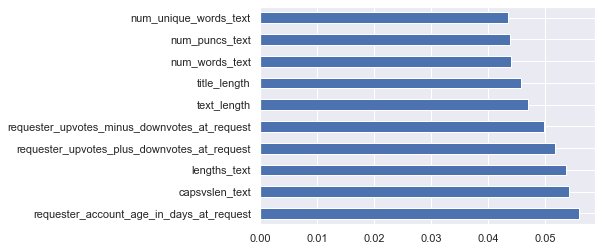

In [208]:
feat_importances = pd.Series(rf_final.feature_importances_, index=Xcols)
feat_importances.nlargest(10).plot(kind='barh')
pass

#### 8.4 Choosing right thresholds and reporting results

Best Threshold=0.209909, F-Score=0.451


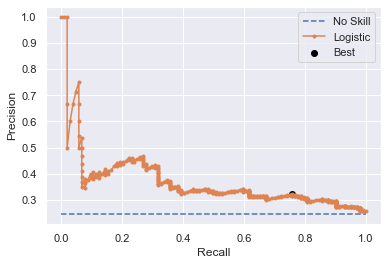

In [209]:
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(val_final[y_col], prediction_probs)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.nanargmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = 0.24505
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [210]:
pred_label = prediction_probs>=0.279234

In [211]:
print(classification_report(y_true=val_final[y_col], y_pred=pred_label))

              precision    recall  f1-score   support

       False       0.79      0.63      0.70       300
        True       0.32      0.51      0.40       104

    accuracy                           0.60       404
   macro avg       0.56      0.57      0.55       404
weighted avg       0.67      0.60      0.62       404



In [240]:
rfprediction = pred_label

In [241]:
rfprediction.shape

(404,)

### KNN Classifier

#### KNN Classifier model fitting 

In [234]:
knnmodel = KNeighborsClassifier(n_jobs=-1)
#learning
knnmodel.fit(train_final[Xcols], train_final[y_col])
#Prediction
knnprediction=knnmodel.predict(val_final[Xcols])

In [238]:
knnprediction.shape

(404,)

#### KNN Classifier Evaluation

In [235]:
#evaluation(Accuracy)
print("Accuracy:",accuracy_score(knnprediction,val_final[y_col]))
#evaluation(Confusion Metrix)
print("Confusion Metrix:\n",confusion_matrix(knnprediction,val_final[y_col]))

Accuracy: 0.7103960396039604
Confusion Metrix:
 [[268  85]
 [ 32  19]]


### SVM

#### SVM Model fitting

In [225]:
#making the instance
svmmodel = svm.SVC(random_state=123)
#learning
svmmodel.fit(train_final[Xcols], train_final[y_col])
#Prediction
svmprediction=svmmodel.predict(val_final[Xcols])

In [239]:
svmprediction.shape

(404,)

#### SVM Model Evaluations

In [229]:
#evaluation(Accuracy)
print("Accuracy:", accuracy_score(svmprediction,val_final[y_col]))
#evaluation(Confusion Metrix)
print("Confusion Metrix:\n", confusion_matrix(svmprediction,val_final[y_col]))

Accuracy: 0.7425742574257426
Confusion Metrix:
 [[300 104]
 [  0   0]]


## Ensemble Modeling

### Max Voting

In [245]:
model1 = rf_final
model2 = knnmodel
model3= svmmodel

pred1=rfprediction
pred2=knnprediction
pred3=svmprediction

final_pred = np.array([])
for i in range(0,len(val_final[y_col])):
    final_pred = np.append(final_pred, mode([pred1[i], pred2[i], pred3[i]]))

In [246]:
print("Accuracy:", accuracy_score(final_pred,val_final[y_col]))

Accuracy: 0.7227722772277227


### Blending

In [249]:
#splitting train further 
train_train, train_eval = train_test_split(train_final, test_size=0.3, random_state=0)

model1.fit(train_train[Xcols], train_train[y_col])
train_eval_pred1=model1.predict(train_eval[Xcols])
eval_pred1=model1.predict(val_final[Xcols])
train_eval_pred1=pd.DataFrame(train_eval_pred1)
eval_pred1=pd.DataFrame(eval_pred1)

model2.fit(train_train[Xcols], train_train[y_col])
train_eval_pred2=model2.predict(train_eval[Xcols])
eval_pred2=model2.predict(val_final[Xcols])
train_eval_pred2=pd.DataFrame(train_eval_pred2)
eval_pred2=pd.DataFrame(eval_pred2)

In [255]:
df_val=pd.concat([train_train[Xcols], train_eval_pred1,train_eval_pred2],axis=1)
df_test=pd.concat([val_final[Xcols], eval_pred1,eval_pred2],axis=1)

lrmodel = LogisticRegression(random_state=1)
lrmodel.fit(df_val,train_train[y_col])
lrmodel.score(df_test,val_final[y_col])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### Boosting

#### AdaBoost

In [213]:
AdaBoostModel = AdaBoostClassifier(random_state=1)
AdaBoostModel.fit(train_final[Xcols], train_final[y_col])
AdaBoostModel.score(val_final[Xcols],val_final[y_col])

0.7376237623762376

#### Gradient Booting (GBM)

In [215]:
gbmmodel= GradientBoostingClassifier(learning_rate=0.01,random_state=1)
gbmmodel.fit(train_final[Xcols], train_final[y_col])
gbmmodel.score(val_final[Xcols],val_final[y_col])

0.745049504950495

#### XGBoost

In [217]:
xgbmodel=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
xgbmodel.fit(train_final[Xcols], train_final[y_col])
xgbmodel.score(val_final[Xcols],val_final[y_col])

NameError: name 'xgb' is not defined